In [ ]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [ ]:
train_dataset =torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='train')
val_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='val')
test_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='test')

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


In [ ]:
BASE_PATH = "./data/VOCdevkit/VOC2007"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
SEG_PATH = os.path.join(BASE_PATH, "SegmentationObject")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [ ]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [ ]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,009145.jpg,motorbike,"[104, 57, 383, 370]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg
1,009145.jpg,motorbike,"[15, 96, 135, 299]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg
2,009145.jpg,person,"[54, 68, 97, 137]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg
3,008784.jpg,car,"[479, 146, 500, 169]",./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg
4,008784.jpg,car,"[429, 139, 484, 168]",./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg


In [ ]:
df['names'].value_counts()

person         10674
car             3185
chair           2806
bottle          1291
pottedplant     1217
bird            1175
dog             1068
sofa             821
bicycle          807
horse            801
boat             791
motorbike        759
cat              759
tvmonitor        728
cow              685
sheep            664
aeroplane        642
train            630
diningtable      609
bus              526
Name: names, dtype: int64

In [ ]:
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,motorbike,"[104, 57, 383, 370]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145
1,motorbike,"[15, 96, 135, 299]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145
2,person,"[54, 68, 97, 137]",./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145
3,car,"[479, 146, 500, 169]",./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg,008784
4,car,"[429, 139, 484, 168]",./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg,008784


In [ ]:
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        10674
car          7          3185
chair        9          2806
bottle       5          1291
pottedplant  16         1217
bird         3          1175
dog          12         1068
sofa         18          821
bicycle      2           807
horse        13          801
boat         4           791
cat          8           759
motorbike    14          759
tvmonitor    20          728
cow          10          685
sheep        17          664
aeroplane    1           642
train        19          630
diningtable  11          609
bus          6           526
dtype: int64

In [ ]:
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [ ]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-13-a8b129e4fc15>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['xmin'] = df['xmin'].astype(np.float)
<ipython-input-13-a8b129e4fc15>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior

In [ ]:
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145,14,104.0,57.0,383.0,370.0
1,./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145,14,15.0,96.0,135.0,299.0
2,./data/VOCdevkit/VOC2007/Annotations/009145.xml,./data/VOCdevkit/VOC2007/JPEGImages/009145.jpg,009145,15,54.0,68.0,97.0,137.0
3,./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg,008784,7,479.0,146.0,500.0,169.0
4,./data/VOCdevkit/VOC2007/Annotations/008784.xml,./data/VOCdevkit/VOC2007/JPEGImages/008784.jpg,008784,7,429.0,139.0,484.0,168.0


In [ ]:
len(df['img_id'].unique())

9963

In [ ]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

5963

In [ ]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((12521, 8), (18117, 8))

In [ ]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

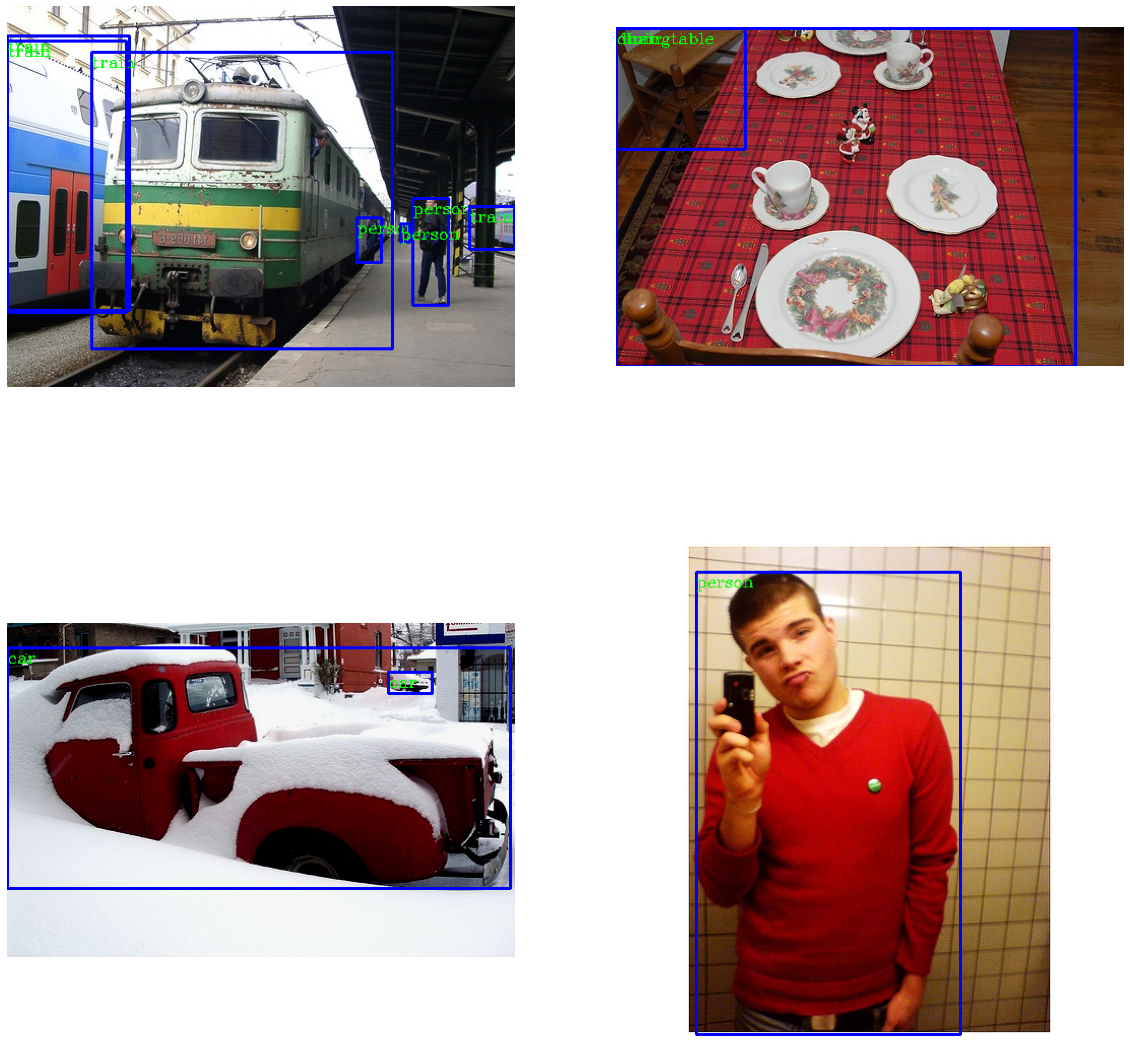

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [ ]:
import scipy.optimize

def box_iou(box1, box2):
    """Compute IoU between two bounding boxes.
    Args:
        box1: (tensor) bounding boxes, sized [N,4].
        box2: (tensor) bounding boxes, sized [M,4].
    Return:
        (tensor) IoU, sized [N,M].
    """
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(
        box1[:, :2].unsqueeze(1).expand(N, M, 2),
        box2[:, :2].unsqueeze(0).expand(N, M, 2),
    )
    rb = torch.min(
        box1[:, 2:].unsqueeze(1).expand(N, M, 2),
        box2[:, 2:].unsqueeze(0).expand(N, M, 2),
    )

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    iou = inter / (area1.unsqueeze(1) + area2.unsqueeze(0) - inter)
    return iou

def hungarian_algorithm(cost_matrix):
    cost_matrix = cost_matrix.numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    return torch.tensor(list(zip(row_ind, col_ind)))

def loss_compute(objs, nobox, cls, target, crit1, crit2, crit3):
    box1 = target['boxes']
    cls1 = target['labels']
    box2 = objs
    cls2 = cls

    cost = box_iou(box1.clone().detach().cpu(), box2.clone().detach().cpu())
    idx = hungarian_algorithm(cost)
    pred_box2 = box2[idx[:, 1]][idx[:, 0]]
    pred_cls2 = cls2[idx[:, 1]][idx[:, 0]]
    pred_nbj2 = torch.zeros((256,)).cuda()
    true_nbj2 = torch.zeros((256,)).cuda()
    true_nbj2[idx[:, 0]] = 1
    pred_nbj2 = nobox
    loss1 = crit1(pred_box2.float(), box1.float())/2560
    loss2 = crit2(pred_cls2, cls1)
    loss3 = crit3(pred_nbj2, true_nbj2)
    return {'loss_reg': loss1, 'loss_class': loss2, 'loss_noobj': loss3}
    #return loss1+loss2+loss3

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


class Permute(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, 768, 16, 16)

class Interpolate(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.size = size

    def forward(self, x):
        h, w = x.shape[-2:]
        x = nn.ZeroPad2d(padding=(0, self.size-w, 0, self.size-h))(x)
        return x

class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.vit_b_32(image_size=512)

    def forward(self, x):
        x = self.model._process_input(x)
        n = x.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.model.encoder(x)
        x = x[:, 1:]

        return x


class ViTBackbone(nn.Module):
    def __init__(self, vit_model, out_channels=768):
        super().__init__()
        self.out_channels = out_channels
        self.layer0 = nn.Sequential(Interpolate(),
                                    vit_model)
        self.bbox_reg = nn.Linear(768, 4)
        self.nobox_reg = nn.Linear(768, 1)
        self.class_reg = nn.Linear(768, 21)
        self.crit1 = torch.nn.MSELoss()
        self.crit2 = torch.nn.CrossEntropyLoss()
        self.crit3 = torch.nn.BCELoss()

    def forward(self, x, target=None):
        if target is not None:
            loss_dicts = {'loss_reg': 0, 'loss_class': 0, 'loss_noobj': 0}
            for i in range(len(x)):
                y = self.layer0(torch.unsqueeze(x[i], 0))
                bbox = self.bbox_reg(y)
                nobox = nn.Softmax(dim=2)(self.nobox_reg(y))
                cls = nn.Softmax(dim=2)(self.class_reg(y))
                h, w = x[i].shape[1:]
                target[i]['boxes'][:, 0] = target[i]['boxes'][:, 0]
                target[i]['boxes'][:, 1] = target[i]['boxes'][:, 1]
                target[i]['boxes'][:, 2] = target[i]['boxes'][:, 2]
                target[i]['boxes'][:, 3] = target[i]['boxes'][:, 3]
                loss_dict = loss_compute(bbox[0], nobox[0, :, 0], cls[0], target[i], self.crit1, self.crit2, self.crit3)
                loss_dicts['loss_reg'] += loss_dict['loss_reg']
                loss_dicts['loss_class'] += loss_dict['loss_class']
                loss_dicts['loss_noobj'] += loss_dict['loss_noobj']
            return loss_dicts
        else:
            preds = []
            for i in range(len(x)):
                y = self.layer0(torch.unsqueeze(x[i], 0))
                bbox = self.bbox_reg(y)
                nobox = nn.Softmax(dim=2)(self.nobox_reg(y))
                cls = nn.Softmax(dim=2)(self.class_reg(y))
                h, w = x[i].shape[1:]
                target = {}
                target['boxes'] = []
                target['boxes'].append(bbox[0, :, 0])
                target['boxes'].append(bbox[0, :, 1])
                target['boxes'].append(bbox[0, :, 2])
                target['boxes'].append(bbox[0, :, 3])
                target['boxes'] = torch.vstack(target['boxes']).T
                target['labels'] = torch.argmax(cls[0], 1)
                target['scores'] = nobox.squeeze()
                preds.append(target)
            return preds

num_classes=21

vit_model = ViTFeatureExtractor()
vit_backbone = ViTBackbone(vit_model)

img = torch.randn((1, 3, 333, 333))
out = vit_backbone(img)

In [ ]:
vit_backbone.cuda()
params = [p for p in vit_backbone.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ta8mwq11
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ta8mwq11
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397881 sha256=947260b06cfa4eb239f34b7f18aee7fabe0f281183bf22796dbfd7cafb2f6eae
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ydn6ibv/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
Cloning into 'vision'...
remote: Enumerating ob

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
num_epochs = 21
vit_backbone.cuda()

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(vit_backbone, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(vit_backbone, valid_data_loader, device=device)

Epoch: [0]  [   0/1491]  eta: 0:23:37  lr: 0.000000  loss: 416.5096 (416.5096)  loss_reg: 9.8638 (9.8638)  loss_class: 10.9427 (10.9427)  loss_noobj: 395.7031 (395.7031)  time: 0.9509  data: 0.6152  max mem: 1972


KeyboardInterrupt: ignored

In [ ]:
vit_backbone.cuda()
for it, (images, targets) in enumerate(train_data_loader):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    for i in range(len(images)):
        objs = vit_backbone(torch.unsqueeze(images[i], 0))
        crit1 = nn.MSELoss()
        crit2 = nn.CrossEntropyLoss()
        crit3 = nn.BCELoss()
        loss = loss_compute(objs, targets[i], crit1, crit2, crit3)
        loss.backward()
    if it%10 == 0:
        print(it)
    optimizer.step()

In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

backbone = resnet_fpn_backbone('resnet50', pretrained=False)

# Create the Faster R-CNN model with ResNet backbone
model = FasterRCNN(backbone, num_classes=21)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
num_epochs = 21

for epoch in range(num_epochs):
    print(epoch)
    # train for one epoch, printing every 10 iterations
    #train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov3/master/requirements.txt  # install dependencies

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to(device)

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
for images, targets in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    print(loss_dict)
    losses = sum(loss for loss in loss_dict.values())

In [ ]:
!pip list

In [ ]:
import torchvision.models as models

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import timm

class Permute(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, 1000, 24, 24)

class Interpolate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return nn.functional.interpolate(x, size=(384, 384),
                                         mode='bilinear',
                                         align_corners=True)

class ViTBackbone(nn.Module):
    def __init__(self, vit_model, out_channels=512):
        super().__init__()
        self.out_channels = out_channels
        self.layer0 = nn.Sequential(Interpolate(),
                                    vit_model.patch_embed,
                                    vit_model.blocks,
                                    vit_model.norm,
                                    vit_model.fc_norm,
                                    vit_model.head,
                                    Permute())
    def forward(self, x):
        x = self.layer0(x)
        return x

num_classes=21

vit_model = timm.create_model('vit_base_patch16_384', pretrained=True)
vit_backbone = ViTBackbone(vit_model)

in_channels_list = [1000]
return_layers = {'layer0': '0'}

out_channels = 1000

backbone = BackboneWithFPN(vit_backbone, return_layers, in_channels_list, out_channels)

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512), (32, 64, 128, 256, 512)),
    aspect_ratios=((0.25, 0.5, 1.0, 2.0), (0.25, 0.5, 1.0, 2.0))
)

# Final Faster RCNN model.
model = FasterRCNN(
    backbone=backbone,
    num_classes=21,
    rpn_anchor_generator=anchor_generator,
)

img = torch.randn((1, 3, 384, 384))
model.eval()
out = model(img)
print(out)

[{'boxes': tensor([[ 17.5276, 330.2975, 136.6066, 358.4138],
        [ 63.6769, 154.7932,  98.9670, 163.0635],
        [169.6427, 236.9908, 178.6217, 252.1879],
        [  0.0000, 175.1965,  14.6768, 239.6512],
        [187.1353, 167.9077, 193.1050, 181.6502],
        [197.6146, 317.8880, 237.2368, 346.3686],
        [169.6581, 237.6575, 178.5987, 251.7458],
        [ 45.9776, 229.7059,  75.6919, 253.3998],
        [ 47.7654, 323.9833, 122.5216, 384.0000],
        [325.8416,  82.3449, 333.1017, 104.8287],
        [149.8930, 143.1321, 291.4257, 165.5291],
        [150.6863, 122.1781, 176.4393, 153.3621],
        [ 66.5138, 319.8501, 111.3546, 365.3203],
        [121.9050, 269.6236, 206.7693, 299.3520],
        [177.7005, 104.0095, 191.8420, 114.2803],
        [284.3203,  40.5145, 339.3472,  95.8919],
        [131.3433,  75.0503, 207.8183, 100.5819],
        [ 46.0260, 181.1103,  55.1832, 201.8194],
        [185.0285, 332.6618, 192.7415, 351.8278],
        [184.5796,  60.4705, 193.1480, 

In [ ]:
pip install timm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 549 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 26.0 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
model.cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
num_epochs = 21

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [   0/1491]  eta: 1:48:24  lr: 0.000010  loss: 3.8760 (3.8760)  loss_classifier: 3.0129 (3.0129)  loss_box_reg: 0.1350 (0.1350)  loss_objectness: 0.6849 (0.6849)  loss_rpn_box_reg: 0.0432 (0.0432)  time: 4.3623  data: 0.3819  max mem: 3704
Epoch: [0]  [  10/1491]  eta: 0:16:40  lr: 0.000060  loss: 3.9251 (3.9785)  loss_classifier: 3.0089 (3.0071)  loss_box_reg: 0.1350 (0.1454)  loss_objectness: 0.6846 (0.6857)  loss_rpn_box_reg: 0.1474 (0.1404)  time: 0.6758  data: 0.0476  max mem: 4300
Epoch: [0]  [  20/1491]  eta: 0:12:17  lr: 0.000110  loss: 3.8872 (3.9469)  loss_classifier: 3.0036 (3.0033)  loss_box_reg: 0.1150 (0.1419)  loss_objectness: 0.6846 (0.6856)  loss_rpn_box_reg: 0.0953 (0.1161)  time: 0.3084  data: 0.0133  max mem: 4301
Epoch: [0]  [  30/1491]  eta: 0:10:43  lr: 0.000160  loss: 3.8816 (3.9351)  loss_classifier: 2.9909 (2.9964)  loss_box_reg: 0.1220 (0.1402)  loss_objectness: 0.6851 (0.6851)  loss_rpn_box_reg: 0.0862 (0.1135)  time: 0.3108  data: 0.0129  max me

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
outputs = model(images)

outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets = outputs

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)